In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from torch.nn import functional as F
from d2l import torch as d2l
from torchvision.models import resnet50
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import pandas as pd

In [2]:
def invert_colors(img):
    return Image.fromarray(255 - torch.tensor(img))

In [3]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=(120, 120),expand=True),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: Image.fromarray(255 - np.array(x))),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.49,0.45,0.42], std=[0.23, 0.224, 0.225]),
])

In [4]:
class CatDogDataset(Dataset):
    def __init__(self, path_dir, transform=None):
        self.path_dir = path_dir
        self.transform = transform
        self.images = os.listdir(self.path_dir)
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_index = self.images[index]
        img_path = os.path.join(self.path_dir,image_index)
        img = Image.open(img_path).convert('RGB')
        label = img_path.split('\\')[-1].split('.')[0]
        label = 0 if 'cat' in label else 1  

        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
train_dataset = CatDogDataset(path_dir=r'D:\什么鬼图片数据集\train', transform=transform)

In [6]:
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_data, test_data = torch.utils.data.random_split(train_dataset, [train_size, test_size])

In [7]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [8]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [9]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [10]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [11]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10),
                    nn.Linear(10,2))

In [12]:
train_iter = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_iter = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

loss 0.108, train acc 0.958, test acc 0.832
502.7 examples/sec on cuda:0


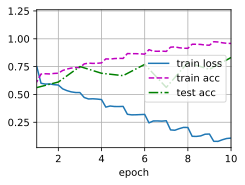

In [13]:
lr, num_epochs = 0.03, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [18]:
net.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

In [14]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.49,0.45,0.42], std=[0.23, 0.224, 0.225]),
])

In [15]:
test_folder_path = r'D:\什么鬼图片数据集\test'
test_file_names = os.listdir(test_folder_path)

In [39]:
class CustomDataset(Dataset):
    def __init__(self, file_names, transform=None):
        self.file_names = file_names
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(test_folder_path, self.file_names[idx])
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)

        return image, int(self.file_names[idx].split('.')[0])

In [40]:
test_dataset = CustomDataset(test_file_names, transform=test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [41]:
probabilities = []

In [44]:
with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(d2l.try_gpu())
        outputs = net(images)
        dog_probabilities = torch.sigmoid(outputs)[:, 1].cpu().numpy()
        probabilities.extend(zip(ids.cpu().numpy(), dog_probabilities))

In [45]:
submission_df = pd.DataFrame(probabilities, columns=['ID', 'TARGET'])
submission_df.to_csv('submission_probabilities.csv', index=False)